In [1]:

import os
import cv2
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sn


In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, Input
import tensorflow as tf

# Configurar TensorFlow para usar solo la CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Define el directorio de la base de datos CK+
directorio = r'C:\Users\joshu\OneDrive\Desktop\archive'


# Define el mapeo de emociones a etiquetas numéricas basadas en las carpetas
emociones = {
    'anger': 0,
    'contempt': 1,
    'disgust': 2,
    'fear': 3,
    'happy': 4,
    'sadness': 5,
    'surprise': 6
}

# Crear listas para las imágenes y las etiquetas
imagenes_data = []
etiquetas = []

# Recorrer las carpetas de emociones
for emocion, etiqueta in emociones.items():
    carpeta_emocion = os.path.join(directorio, emocion)
    if not os.path.exists(carpeta_emocion):
        continue
    contenido = os.listdir(carpeta_emocion)

    # Cargar imágenes y etiquetas
    for nombre_imagen in contenido:
        ruta_imagen = os.path.join(carpeta_emocion, nombre_imagen)
        if nombre_imagen.endswith(('.png', '.jpg', '.jpeg', '.tiff')):
            imagen_actual = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
            imagen_actual = cv2.resize(imagen_actual, (128, 128))  # Reducir tamaño
            imagen_rgb = cv2.cvtColor(imagen_actual, cv2.COLOR_GRAY2RGB)
            imagen_rgb = imagen_rgb / 255.0  # Normalizar
            imagenes_data.append(imagen_rgb)
            etiquetas.append(etiqueta)

# Convertir listas a arreglos numpy
imagenes_data = np.array(imagenes_data)
etiquetas = np.array(etiquetas)

# Separar los datos en conjuntos de entrenamiento y validación
imagenes_train, imagenes_val, etiquetas_train, etiquetas_val = train_test_split(
    imagenes_data, etiquetas, test_size=0.2, random_state=42
)

# Configurar aumento de datos
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Ajustar el generador al conjunto de entrenamiento
datagen.fit(imagenes_train)

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


# Definir la entrada
input_shape = (128, 128, 3)

model = models.Sequential()

# Primera capa convolucional con Depthwise separable para mantener eficiencia
model.add(layers.Conv2D(8, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(16, (1, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Segunda serie de capas convolucionales
model.add(layers.Conv2D(32, (1, 1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (1, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Bloque final con convoluciones y pooling global
model.add(layers.Conv2D(64, (1, 1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (1, 1), padding='same', activation='relu'))
model.add(layers.GlobalAveragePooling2D())

# Capas densas finales con Dropout y regularización
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.4))  # Dropout ajustado para reducir sobreajuste
model.add(layers.Dense(7, activation='softmax'))

# Compilación del modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Implementar EarlyStopping y reducción de learning rate en Plateau
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10)
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Definir un callback personalizado para calcular F1, Precision, y Recall
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.f1s = []
        self.precisions = []
        self.recalls = []

    def on_epoch_end(self, epoch, logs=None):
        val_predicciones = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        val_etiquetas = self.validation_data[1]
        
        f1 = f1_score(val_etiquetas, val_predicciones, average='weighted')
        precision = precision_score(val_etiquetas, val_predicciones, average='weighted')
        recall = recall_score(val_etiquetas, val_predicciones, average='weighted')
        
        self.f1s.append(f1)
        self.precisions.append(precision)
        self.recalls.append(recall)
        
        print(f"Epoch {epoch+1} — F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    # Sobrescribimos el método set_validation_data para obtener el conjunto de validación
    def set_validation_data(self, validation_data):
        self.validation_data = validation_data

# Instanciar el callback y pasar los datos de validación explícitamente
metrics_callback = MetricsCallback()
metrics_callback.set_validation_data((imagenes_val, etiquetas_val))
# Configurar TensorFlow para usar solo la CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


# Entrenar el modelo con el callback
history = model.fit(
    imagenes_train, etiquetas_train,
    validation_data=(imagenes_val, etiquetas_val),
    epochs=200,
    batch_size=2,
    callbacks=[metrics_callback]
)

# Graficar F1, Precision y Recall a lo largo de las épocas
epocas = range(1, len(metrics_callback.f1s) + 1)

plt.figure()
plt.plot(epocas, metrics_callback.f1s, label='F1 Score')
plt.plot(epocas, metrics_callback.precisions, label='Precision')
plt.plot(epocas, metrics_callback.recalls, label='Recall')
plt.title('F1, Precision y Recall a lo largo de las épocas')
plt.xlabel('Épocas')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Resumen del modelo
model.summary()

import os
import cv2
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Función para calcular F1, Precision, y Recall
def calcular_metricas(model, imagenes_val, etiquetas_val):
    predicciones = model.predict(imagenes_val)
    predicciones_clases = np.argmax(predicciones, axis=1)
    
    f1 = f1_score(etiquetas_val, predicciones_clases, average='weighted')
    precision = precision_score(etiquetas_val, predicciones_clases, average='weighted')
    recall = recall_score(etiquetas_val, predicciones_clases, average='weighted')
    
    return f1, precision, recall

def calcular_flops(model):
    # Crear una función concreta del modelo
    imagen_de_prueba = tf.random.normal([1, 128, 128, 3])  # Imagen de prueba
    modelo_funcional = tf.function(lambda x: model(x))
    modelo_concreto = modelo_funcional.get_concrete_function(imagen_de_prueba)

    # Convertir el modelo concreto a un gráfico de TensorFlow
    frozen_func = convert_variables_to_constants_v2(modelo_concreto)
    frozen_func.graph.as_graph_def()

    # Utilizar tf.compat.v1.profiler para obtener el número de FLOPS
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    # Iniciar el profiler
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, cmd='scope', options=opts)

    # Devolver los FLOPS
    return flops.total_float_ops  # Esta función devuelve el número total de operaciones de punto flotante


# Función para calcular la huella de memoria
def calcular_memoria_modelo(model):
    # Contar los parámetros del modelo
    total_params = model.count_params()
    
    # Asumiendo que los parámetros están almacenados en float32 (4 bytes por parámetro)
    bytes_por_param = 4
    memoria_total = total_params * bytes_por_param
    
    # Convertir a MB
    memoria_total_mb = memoria_total / (1024 ** 2)
    return memoria_total_mb

# Obtener métricas en el conjunto de validación
f1, precision, recall = calcular_metricas(model, imagenes_val, etiquetas_val)

# Obtener los parámetros del modelo
parametros = model.count_params()

# Extraer Accuracy y Loss de la última época
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

# Calcular FLOPS y huella de memoria
flops = calcular_flops(model)
memoria_modelo = calcular_memoria_modelo(model)

# Imprimir la tabla con los resultados
print(f"Acc: {acc}, F1: {f1}, P: {precision}, R: {recall}, Loss: {loss}, Parámetros: {parametros}, FLOPS: {flops}, Memoria: {memoria_modelo:.2f} MB")

import pandas as pd

# Crear un diccionario con los resultados de la última época
resultados = {
    'Métrica': ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'Loss', 'Parámetros', 'FLOPS', 'Memoria (MB)'],
    'Valor': [acc, f1, precision, recall, loss, parametros, flops, memoria_modelo]
}

# Convertir el diccionario en un DataFrame de pandas
df_resultados = pd.DataFrame(resultados)

# Guardar la tabla en un archivo Excel
#ruta_excel = r"C:\Users\joshu\OneDrive\Desktop\MNJ2MPCK.xlsx"
#df_resultados.to_excel(ruta_excel, index=False)

# Mostrar el archivo guardado
#ruta_excel
# Graficar las métricas
epocas = range(len(history.history['accuracy']))

# Graficar Accuracy
plt.figure()
plt.plot(epocas, history.history['accuracy'], label='Entrenamiento')
plt.plot(epocas, history.history['val_accuracy'], label='Validación')
plt.title('Accuracy por Época')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Graficar Loss
plt.figure()
plt.plot(epocas, history.history['loss'], label='Entrenamiento')
plt.plot(epocas, history.history['val_loss'], label='Validación')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar F1, Precision, Recall
metricas = ['F1 Score', 'Precision', 'Recall']
valores = [f1, precision, recall]

plt.figure()
plt.bar(metricas, valores)
plt.title('F1, Precision y Recall en la última época')
plt.ylabel('Valor')
plt.show()


# Realizar predicciones con el modelo
y_pred = model.predict(imagenes_val)
y_pred_clases = np.argmax(y_pred, axis=1)

# Calcular métricas de evaluación
acc_val = accuracy_score(etiquetas_val, y_pred_clases)

# Matriz de confusión de validación
matriz_confusion_val = confusion_matrix(etiquetas_val, y_pred_clases)

# Visualizar la matriz de confusión
ax = sn.heatmap(matriz_confusion_val, annot=True, cmap='Blues')
ax.set_title('Validation data Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Ajustar los labels de los ticks
ax.xaxis.set_ticklabels(['NE', 'HA', 'SA', 'SU', 'AN', 'DI', 'FE'])
ax.yaxis.set_ticklabels(['NE', 'HA', 'SA', 'SU', 'AN', 'DI', 'FE'])

plt.show()

# Informe de clasificación
target_names = ['NE', 'HA', 'SA', 'SU', 'AN', 'DI', 'FE']
report = classification_report(etiquetas_val, y_pred_clases, digits=4, target_names=target_names)
print(report)




Epoch 1/200
7/7 [==============================] - 0s 16ms/step- loss: 2.4436 - accuracy: 0.
Epoch 1 — F1: 0.0221, Precision: 0.0255, Recall: 0.0508
392/392 [==============================] - 6s 12ms/step - loss: 2.4421 - accuracy: 0.2041 - val_loss: 2.3122 - val_accuracy: 0.0508
Epoch 2/200
 19/392 [>.............................] - ETA: 3s - loss: 2.2374 - accuracy: 0.3421

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 16ms/step- loss: 2.2033 - accuracy: 0.
Epoch 2 — F1: 0.0850, Precision: 0.0522, Recall: 0.2284
392/392 [==============================] - 4s 11ms/step - loss: 2.2039 - accuracy: 0.2474 - val_loss: 2.1732 - val_accuracy: 0.2284
Epoch 3/200
 18/392 [>.............................] - ETA: 3s - loss: 2.1946 - accuracy: 0.1944

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 15ms/step- loss: 2.1427 - accuracy: 0.
Epoch 3 — F1: 0.0850, Precision: 0.0522, Recall: 0.2284
392/392 [==============================] - 4s 11ms/step - loss: 2.1432 - accuracy: 0.2628 - val_loss: 2.1053 - val_accuracy: 0.2284
Epoch 4/200
 18/392 [>.............................] - ETA: 3s - loss: 2.0693 - accuracy: 0.3056

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 17ms/step- loss: 2.0992 - accuracy: 0.
Epoch 4 — F1: 0.0857, Precision: 0.0527, Recall: 0.2284
392/392 [==============================] - 4s 11ms/step - loss: 2.0975 - accuracy: 0.2615 - val_loss: 2.0658 - val_accuracy: 0.2284
Epoch 5/200
 19/392 [>.............................] - ETA: 3s - loss: 2.1287 - accuracy: 0.1842

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 16ms/step- loss: 2.0485 - accuracy: 0.
Epoch 5 — F1: 0.0850, Precision: 0.0522, Recall: 0.2284
392/392 [==============================] - 4s 11ms/step - loss: 2.0485 - accuracy: 0.2666 - val_loss: 2.0196 - val_accuracy: 0.2284
Epoch 6/200
 17/392 [>.............................] - ETA: 3s - loss: 2.1809 - accuracy: 0.2353

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


388/392 [============================>.] - ETA: 0s - loss: 2.0332 - accuracy: 0.2680

KeyboardInterrupt: 

VISUALIZACIONES DE PESO Y DATOS ESTADISTICOS

1/1 [==============================] - 0s 125ms/step
Visualizando activaciones para la capa: conv2d


C:\Users\joshu\AppData\Local\Temp\ipykernel_14872\3824027362.py:35: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


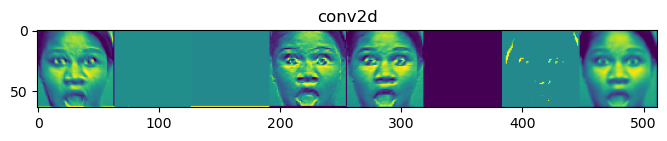

Visualizando activaciones para la capa: batch_normalization


C:\Users\joshu\AppData\Local\Temp\ipykernel_14872\3824027362.py:35: RuntimeWarning: divide by zero encountered in divide
  channel_image /= channel_image.std()


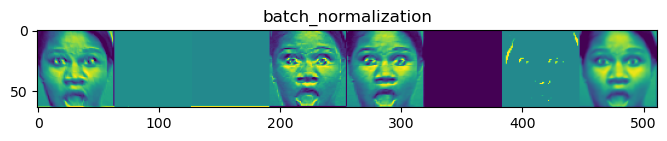

Visualizando activaciones para la capa: depthwise_conv2d


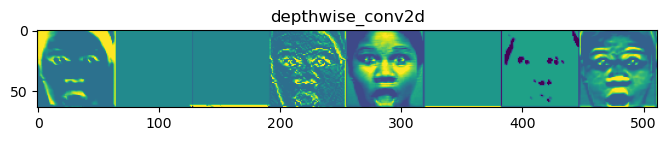

Visualizando activaciones para la capa: batch_normalization_1


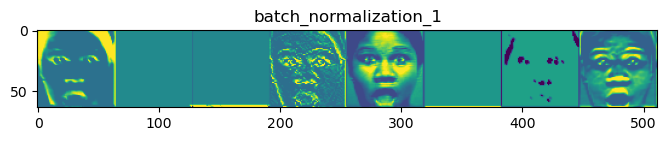

Visualizando activaciones para la capa: conv2d_1


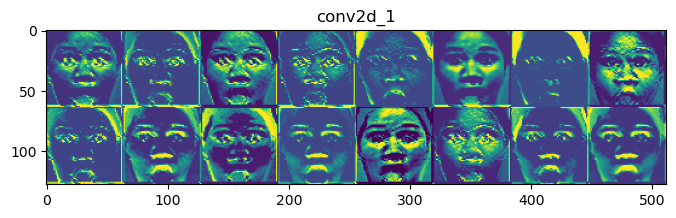

Visualizando activaciones para la capa: max_pooling2d


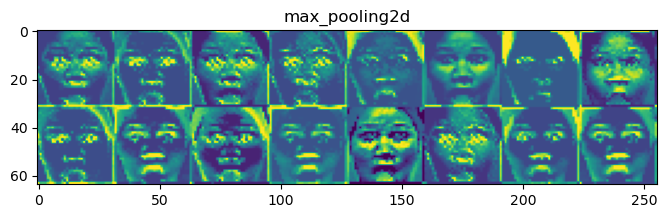

Visualizando activaciones para la capa: conv2d_2


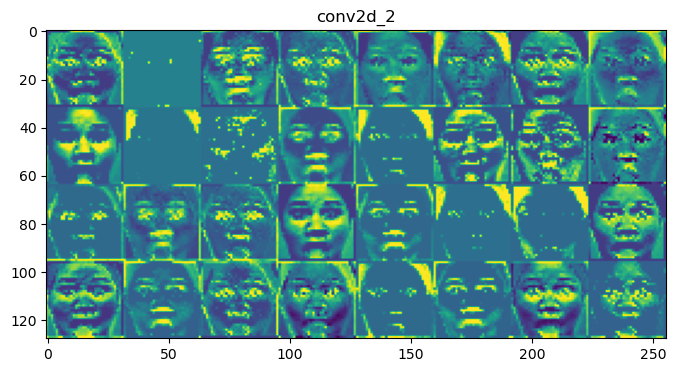

Visualizando activaciones para la capa: batch_normalization_2


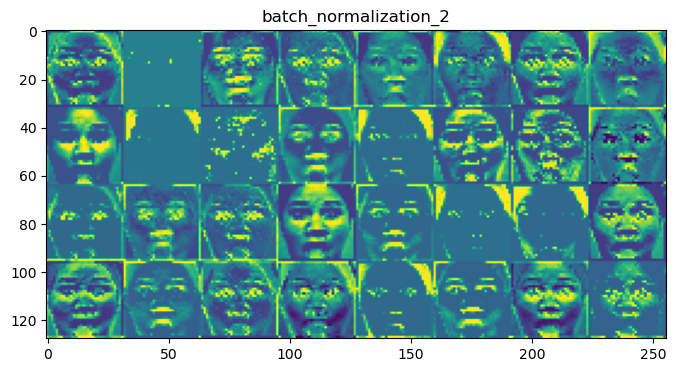

Visualizando activaciones para la capa: depthwise_conv2d_1


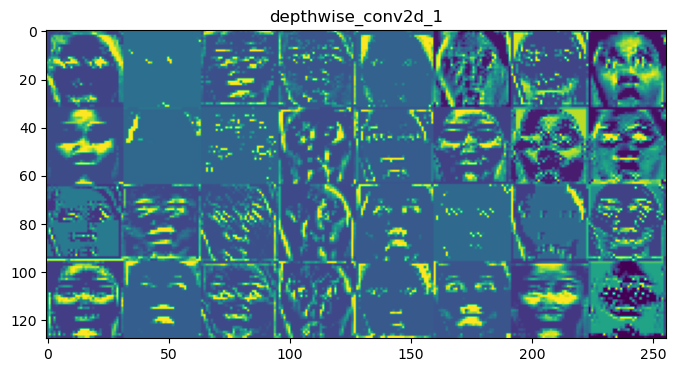

Visualizando activaciones para la capa: batch_normalization_3


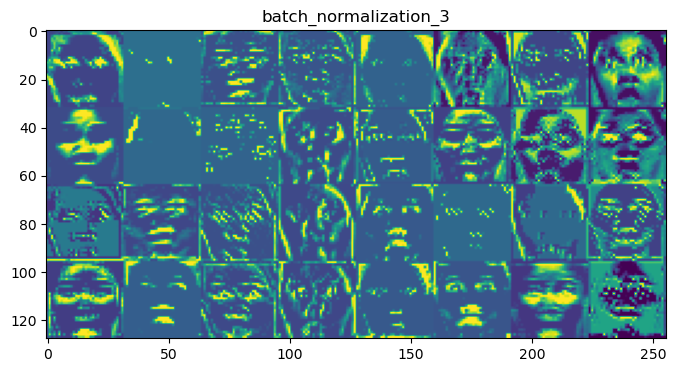

Visualizando activaciones para la capa: conv2d_3


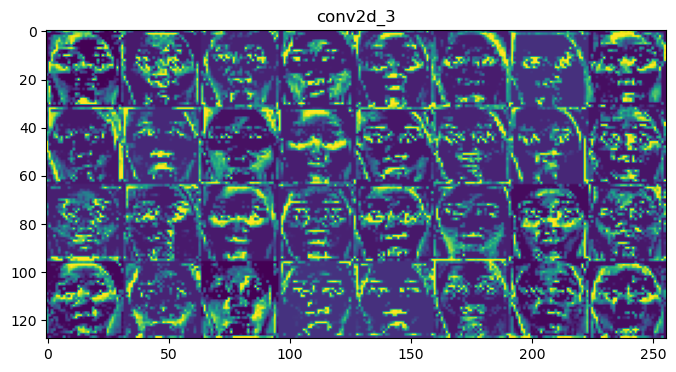

Visualizando activaciones para la capa: max_pooling2d_1


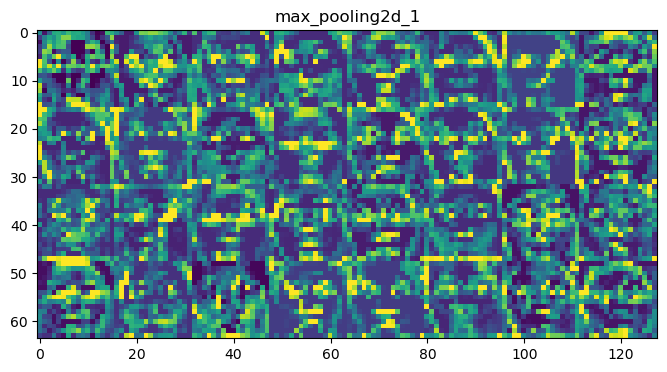

Visualizando activaciones para la capa: conv2d_4


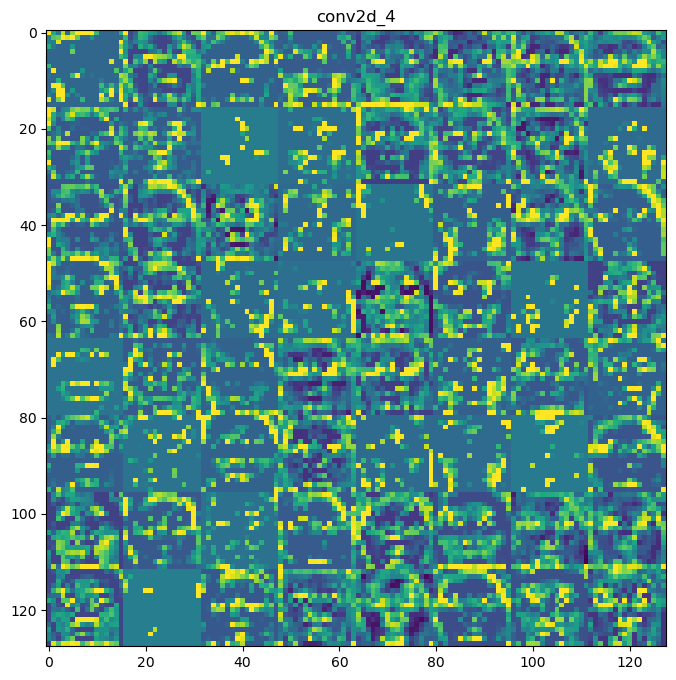

Visualizando activaciones para la capa: batch_normalization_4


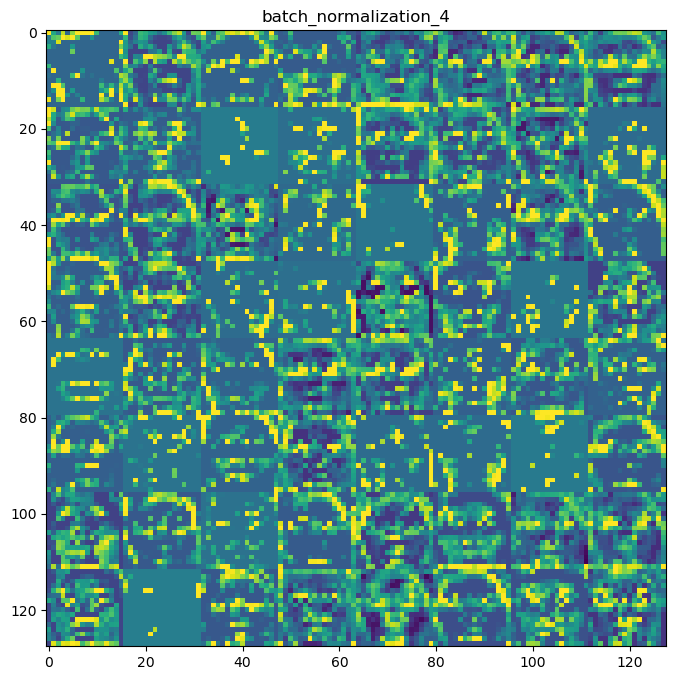

Visualizando activaciones para la capa: depthwise_conv2d_2


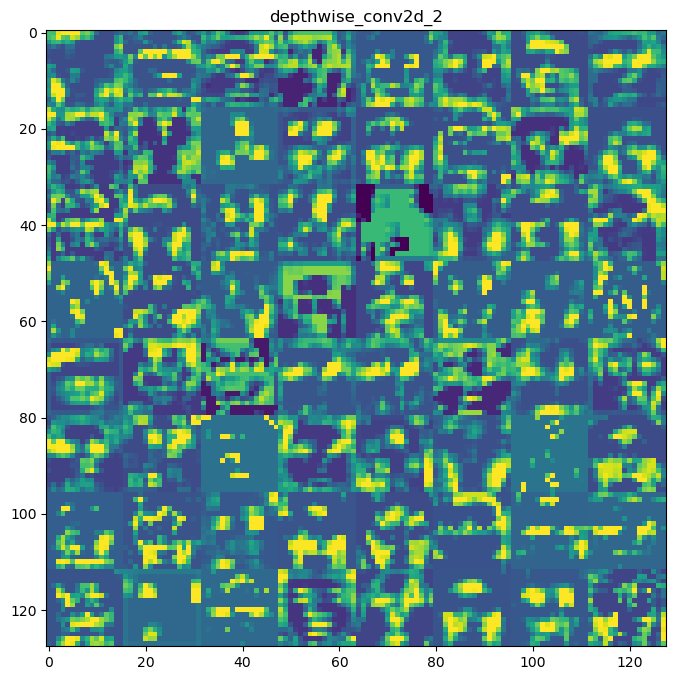

Visualizando activaciones para la capa: batch_normalization_5


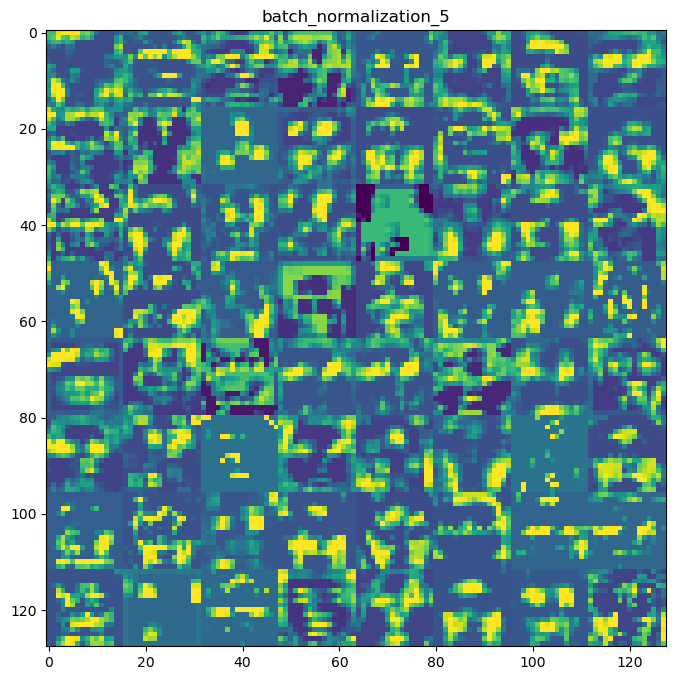

Visualizando activaciones para la capa: conv2d_5


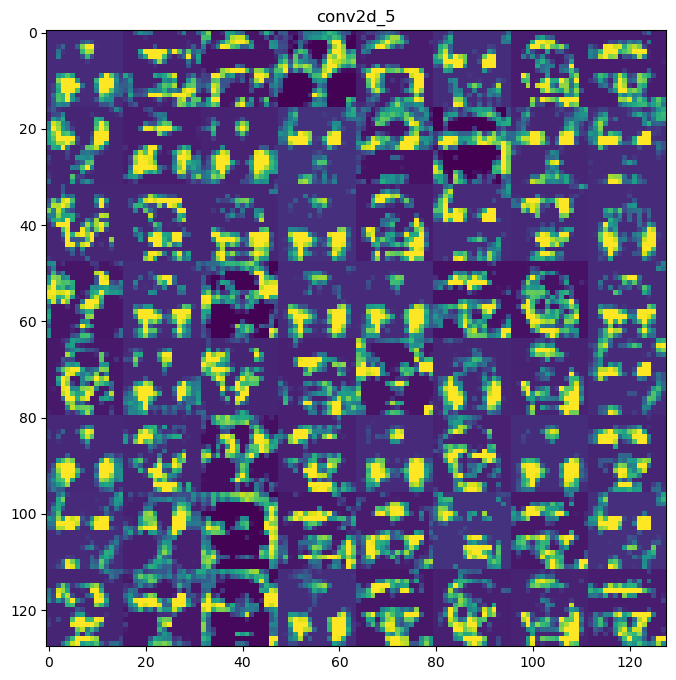

Visualizando activaciones para la capa: global_average_pooling2d


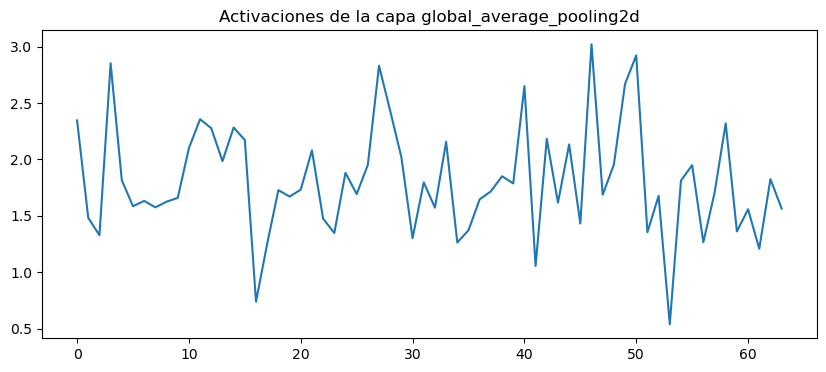

Visualizando activaciones para la capa: dense


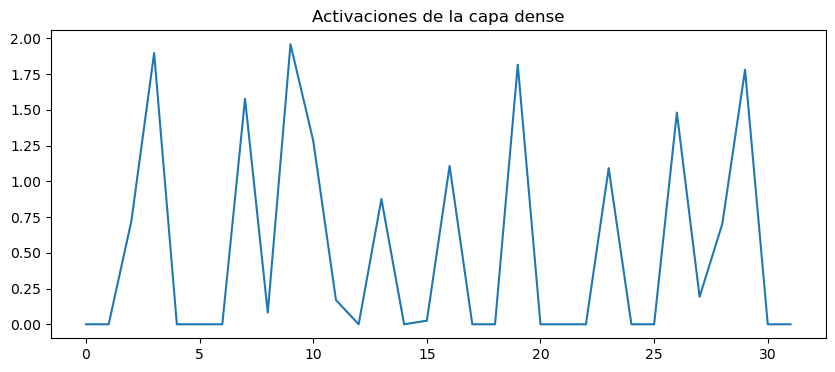

Visualizando activaciones para la capa: dropout


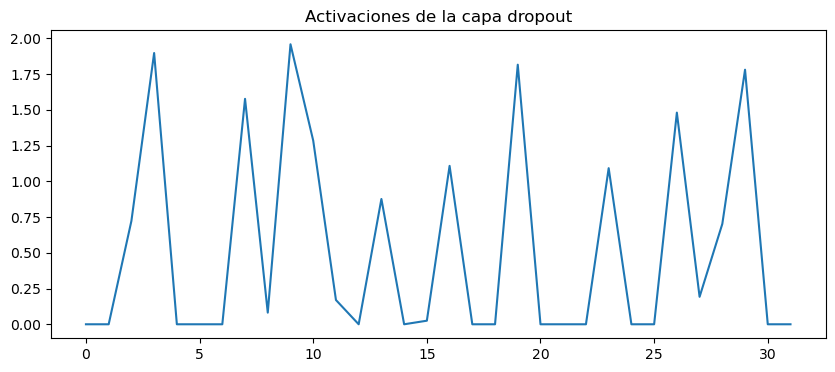

Visualizando activaciones para la capa: dense_1


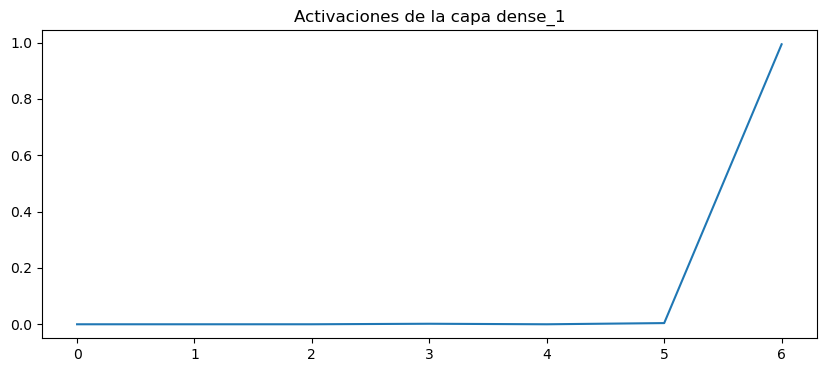

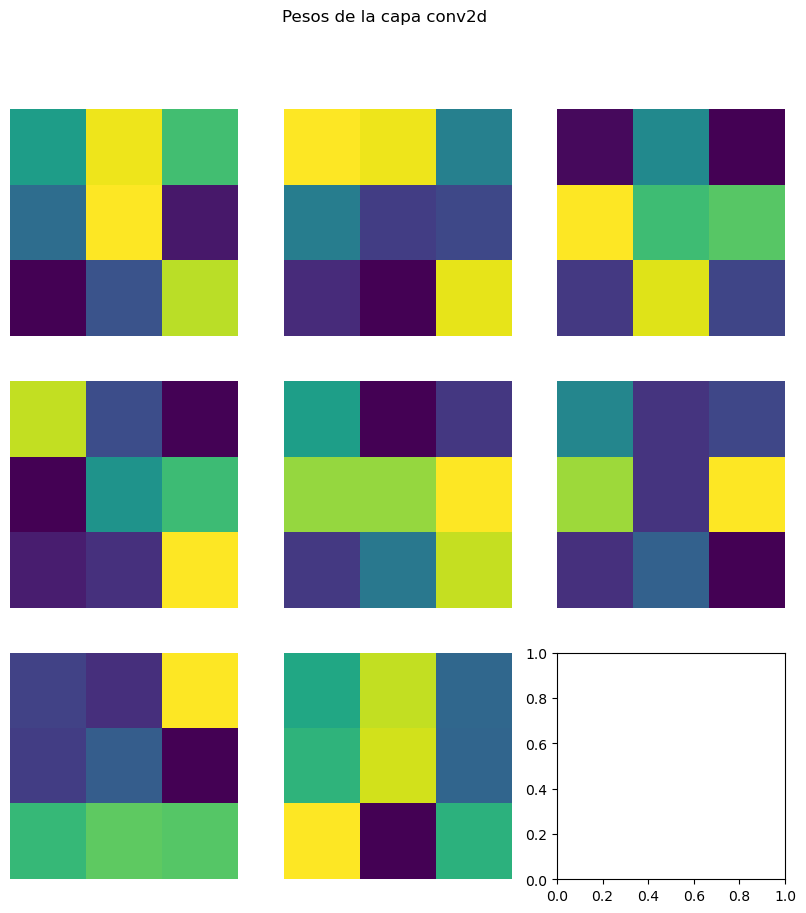

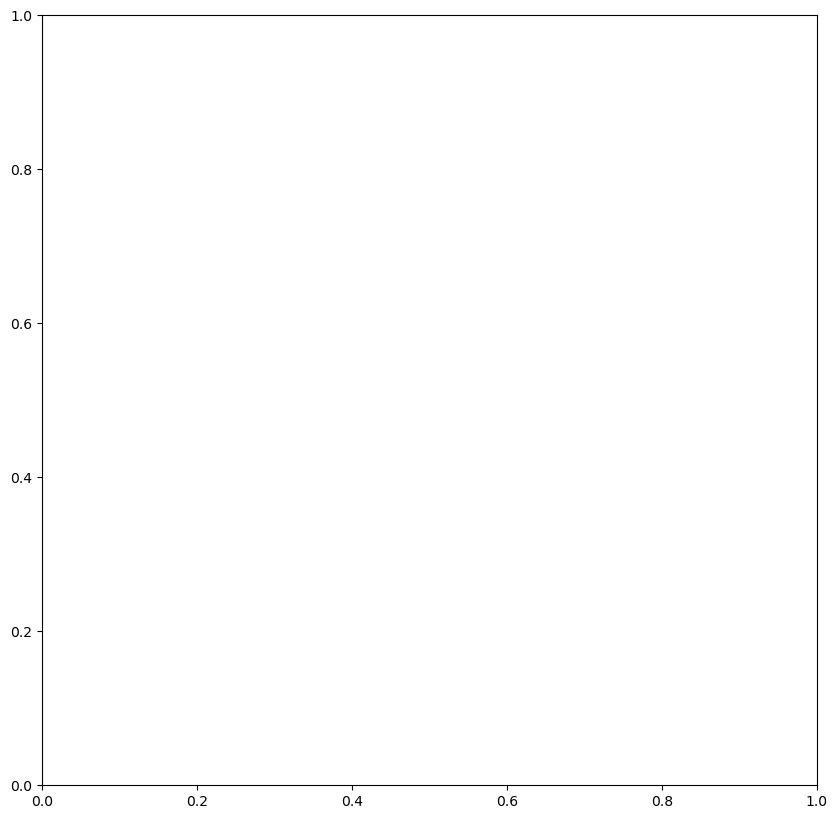

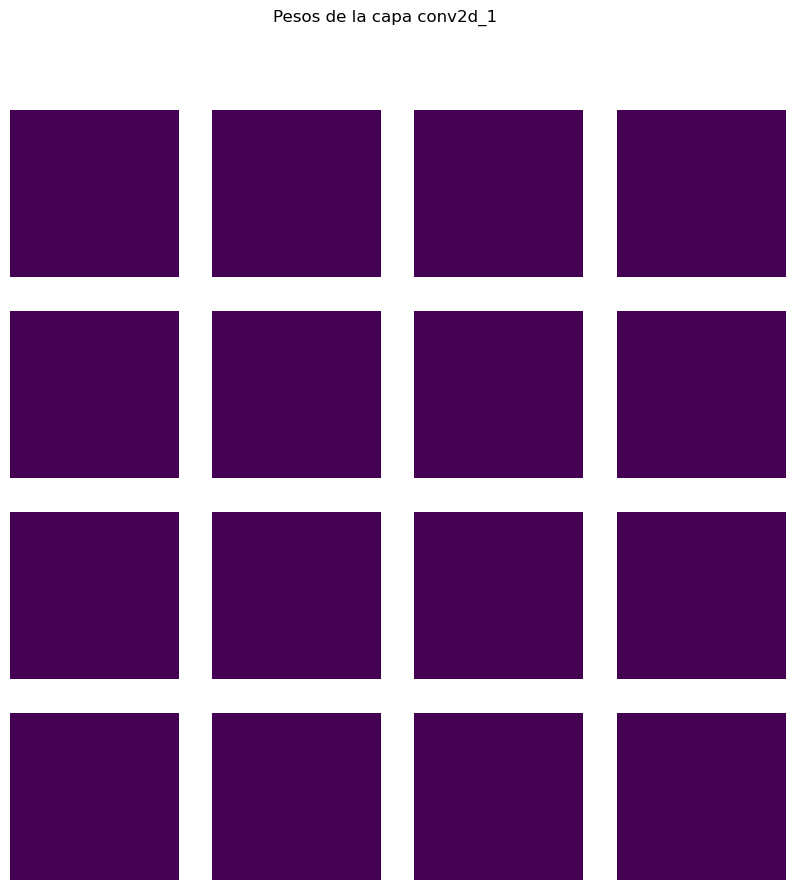

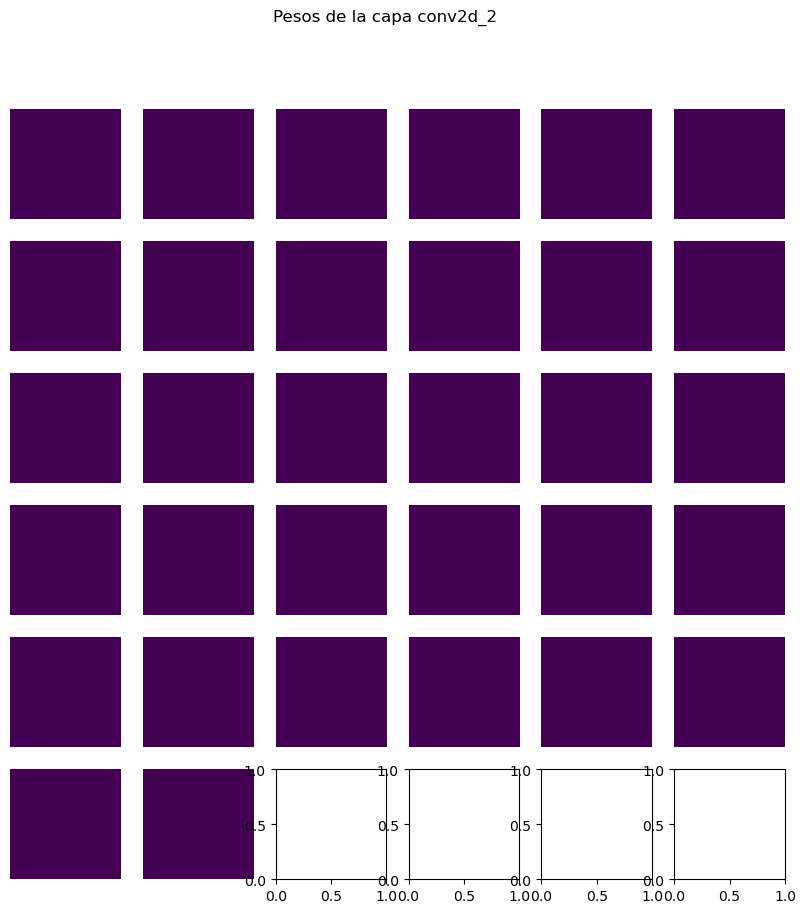

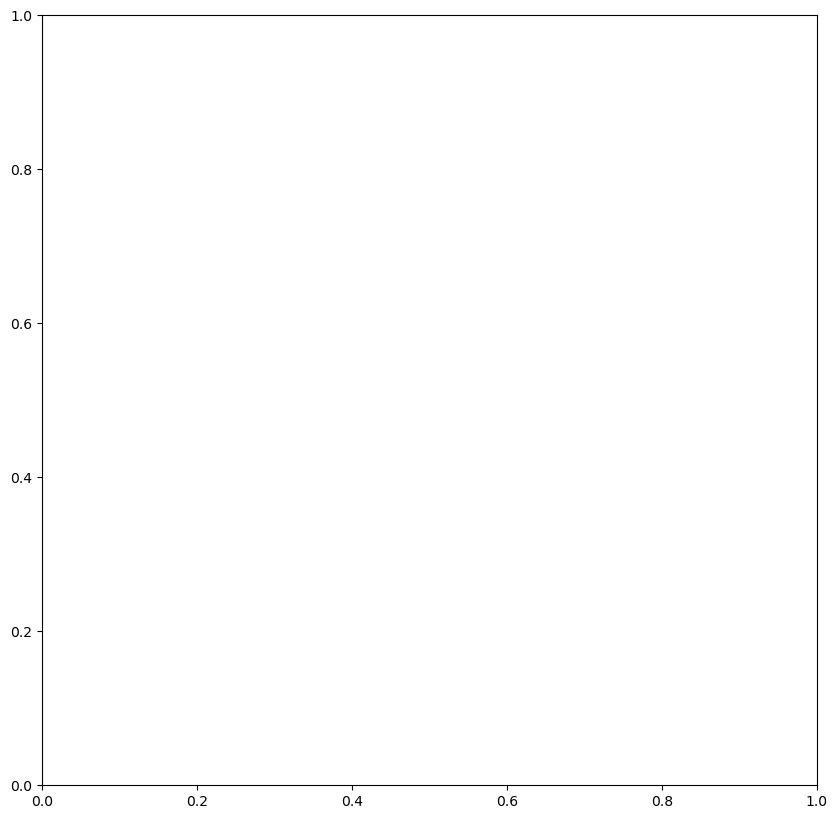

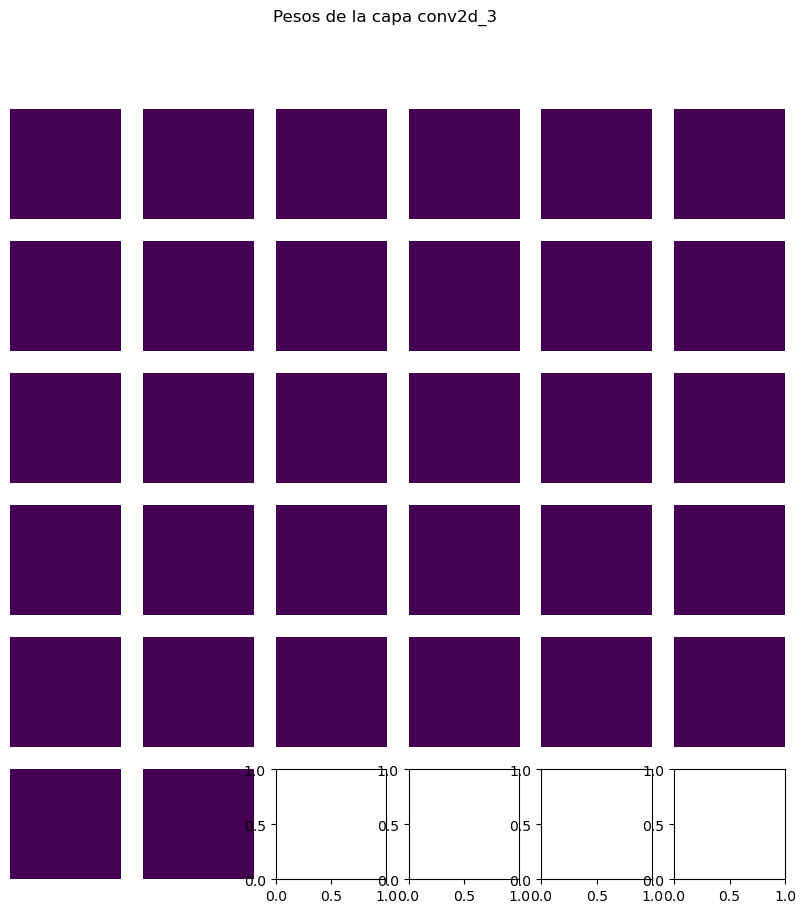

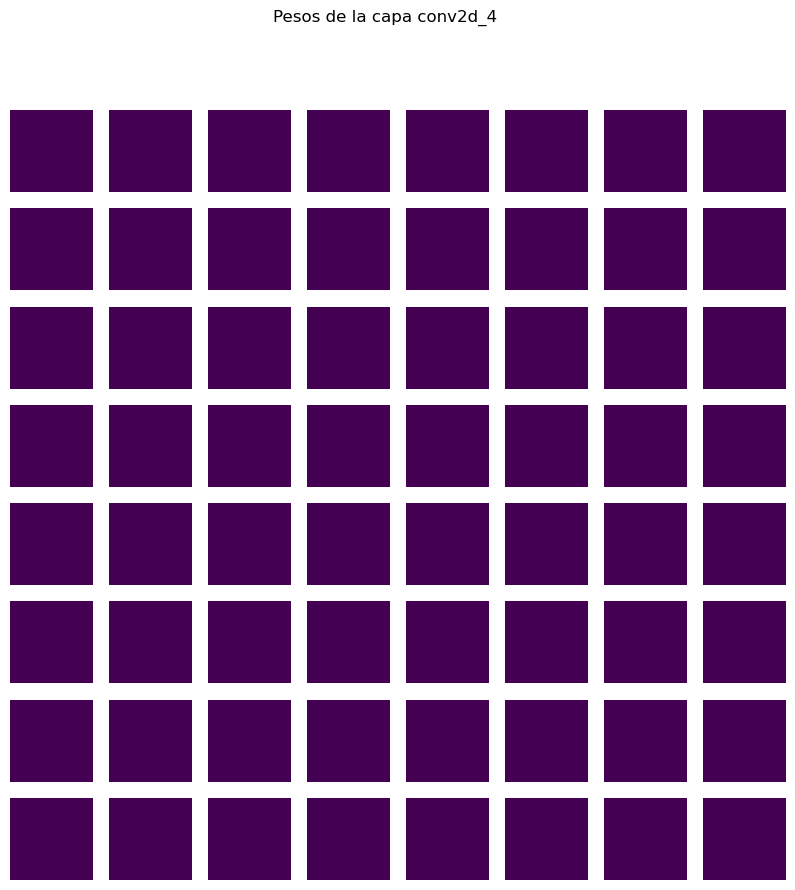

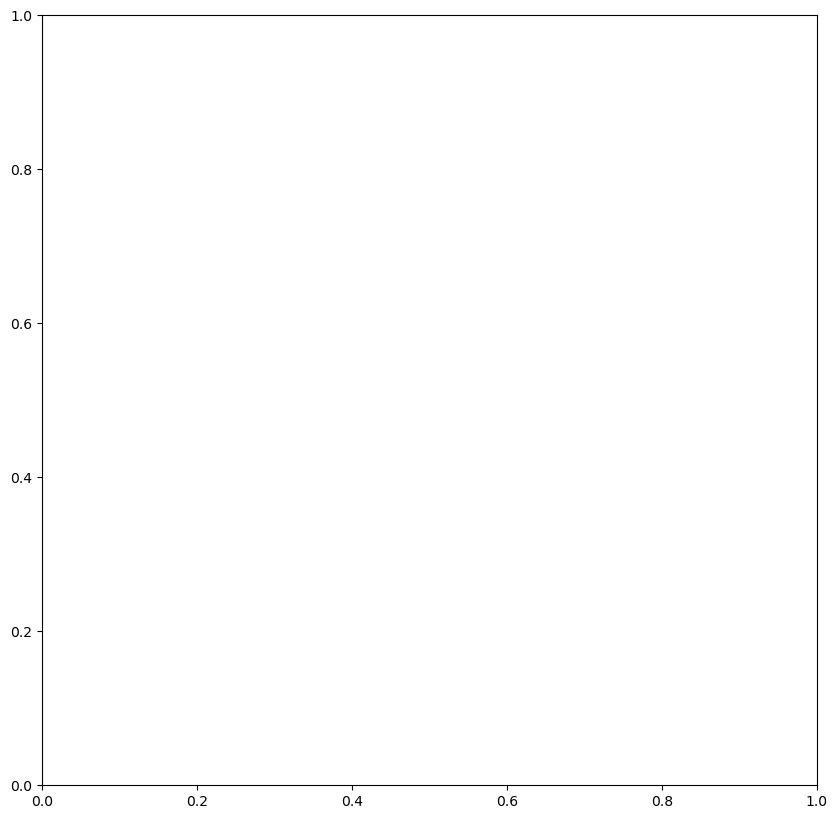

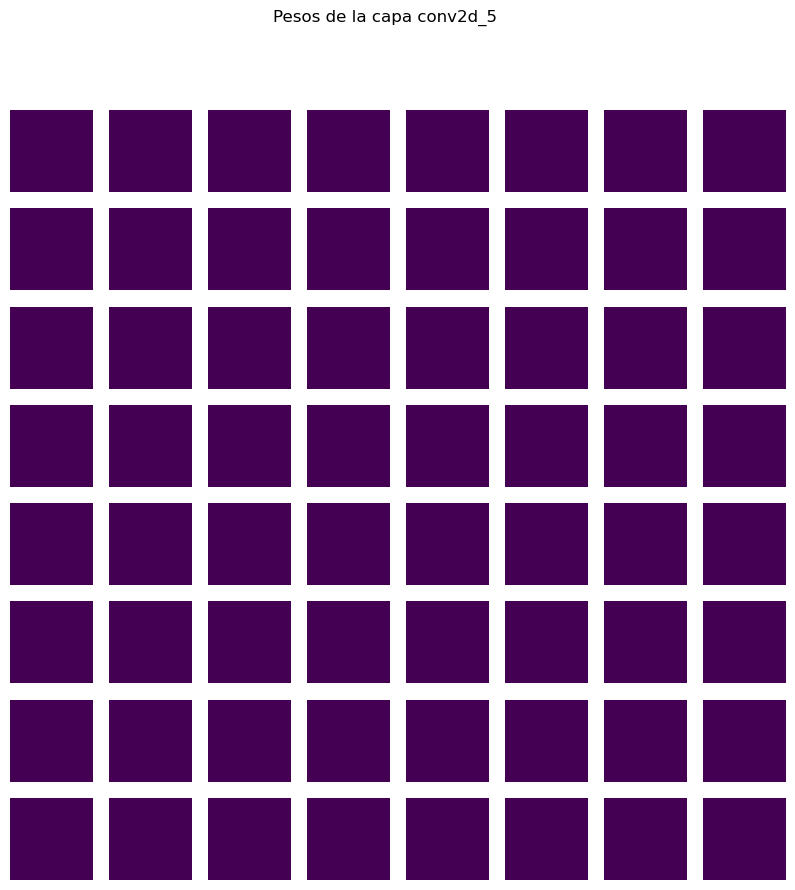

Capa: conv2d
  Media: -0.010948754847049713
  Varianza: 0.021773938089609146
  Asimetría: 0.07518598538367743
  Curtosis: -1.0585801660712133
  Entropía: -682.270530248502
  Rango: 0.6421278715133667


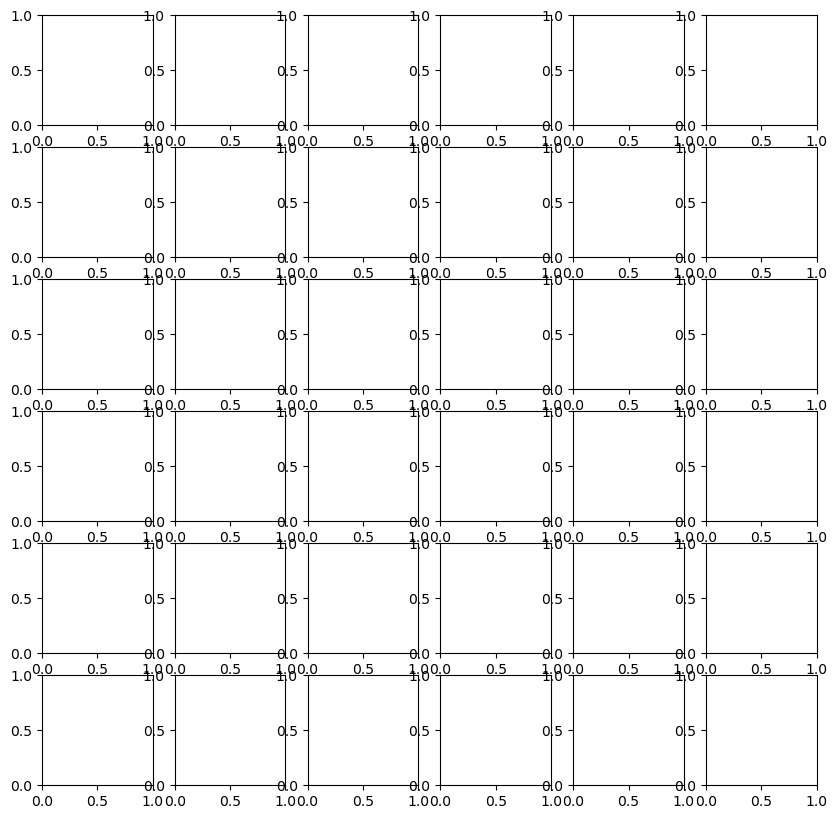

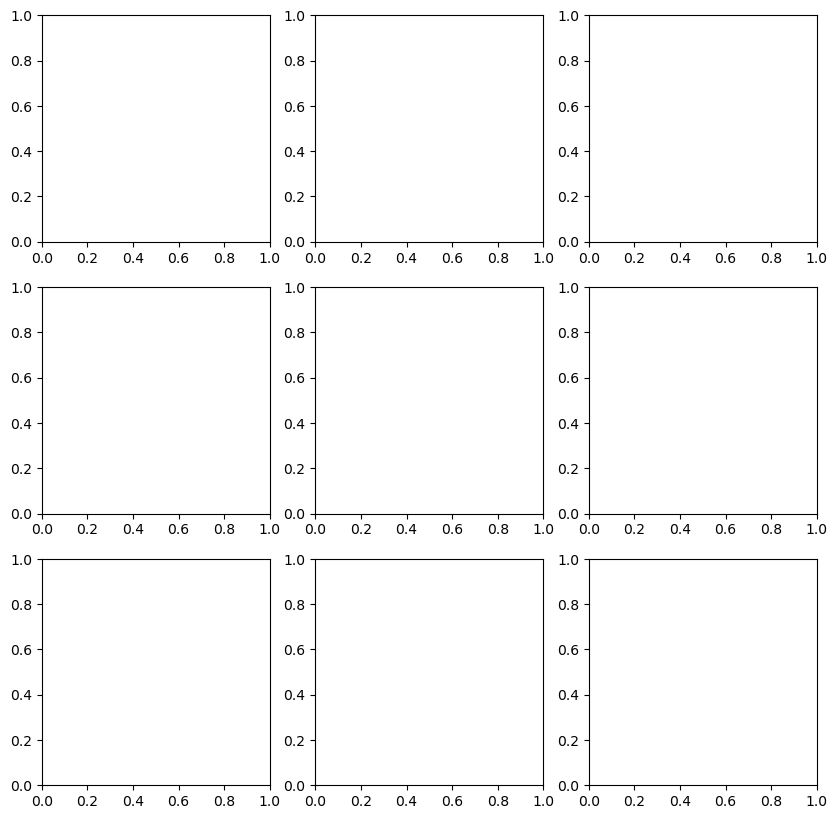

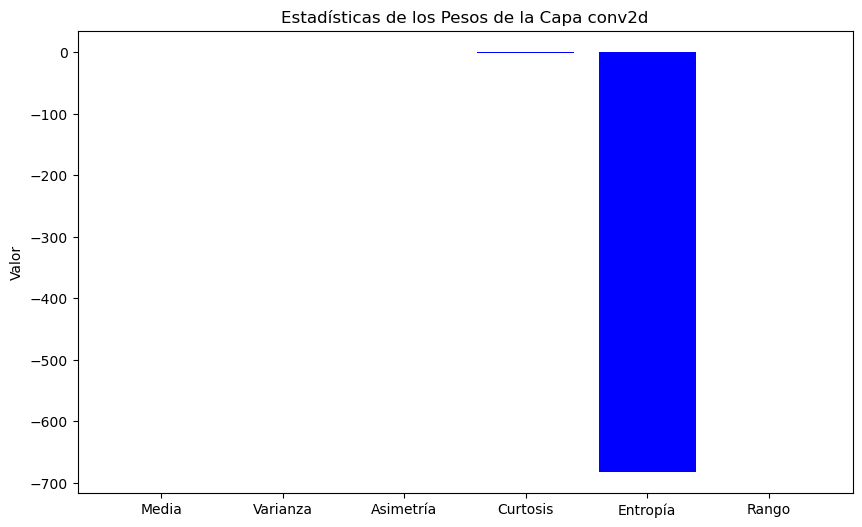

Capa: depthwise_conv2d
  Media: -0.007777758873999119
  Varianza: 0.02476973459124565
  Asimetría: -0.09432582579303118
  Curtosis: -0.8718919912016774
  Entropía: -1165.1784645981925
  Rango: 0.6044043302536011


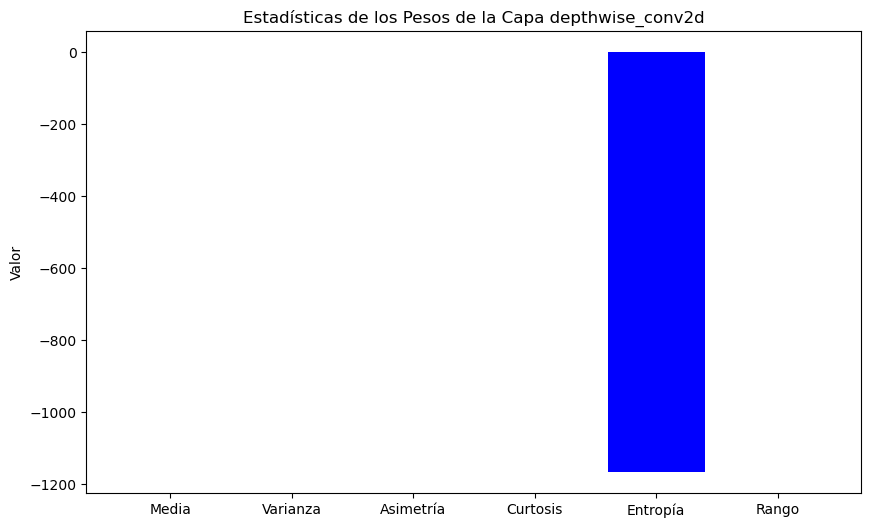

Capa: conv2d_1
  Media: -0.007925101555883884
  Varianza: 0.08183379471302032
  Asimetría: -0.11099973790421867
  Curtosis: -1.0294264621645521
  Entropía: -248.48626234535567
  Rango: 1.2676177024841309


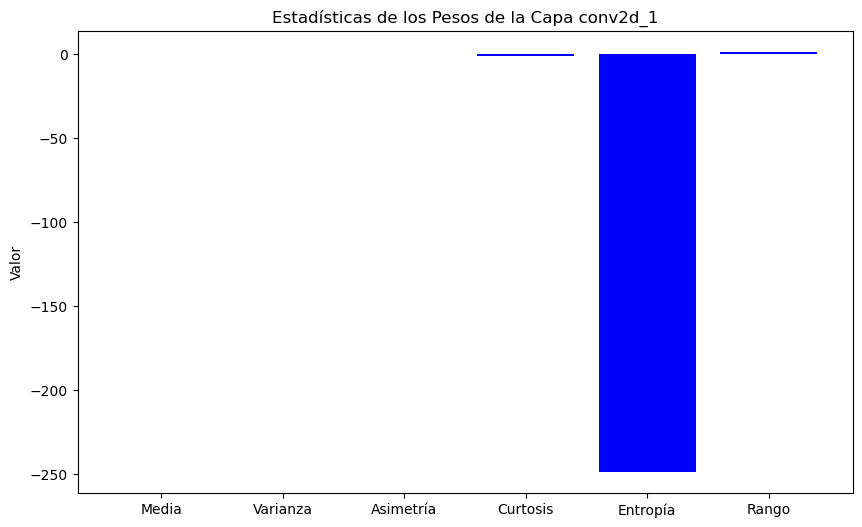

Capa: conv2d_2
  Media: 0.004787242040038109
  Varianza: 0.0414012186229229
  Asimetría: -0.023149725362898492
  Curtosis: -0.9542941496772799
  Entropía: -194.36490679559523
  Rango: 0.9540072679519653


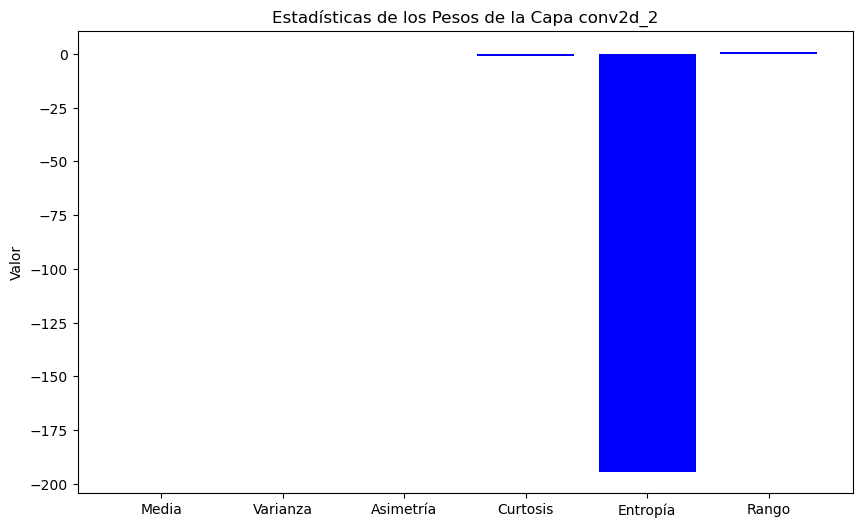

Capa: depthwise_conv2d_1
  Media: 0.0034630633890628815
  Varianza: 0.007374407723546028
  Asimetría: 0.03286055179324995
  Curtosis: -0.5826964364011564
  Entropía: -1271.9894181411628
  Rango: 0.43843546509742737


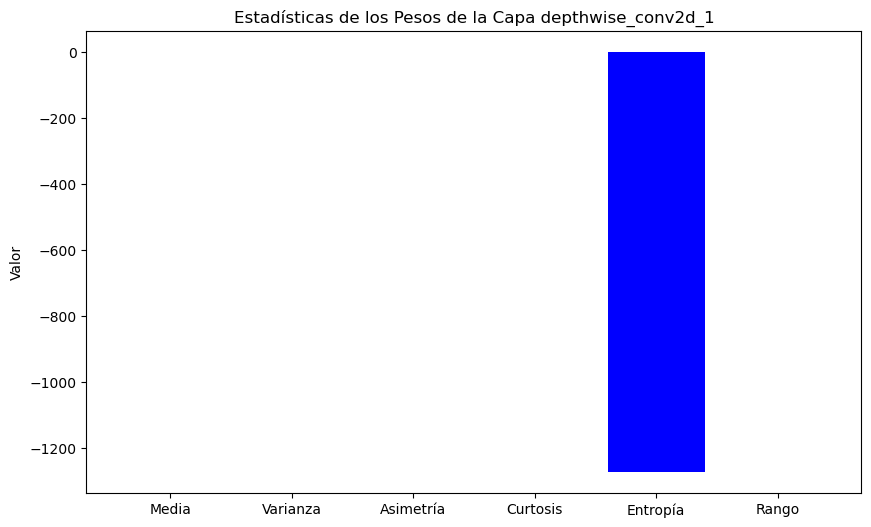

Capa: conv2d_3
  Media: -0.004090524278581142
  Varianza: 0.033433426171541214
  Asimetría: 0.0025048289971422557
  Curtosis: -0.9663489845926145
  Entropía: -182.98337580401088
  Rango: 0.9461942911148071


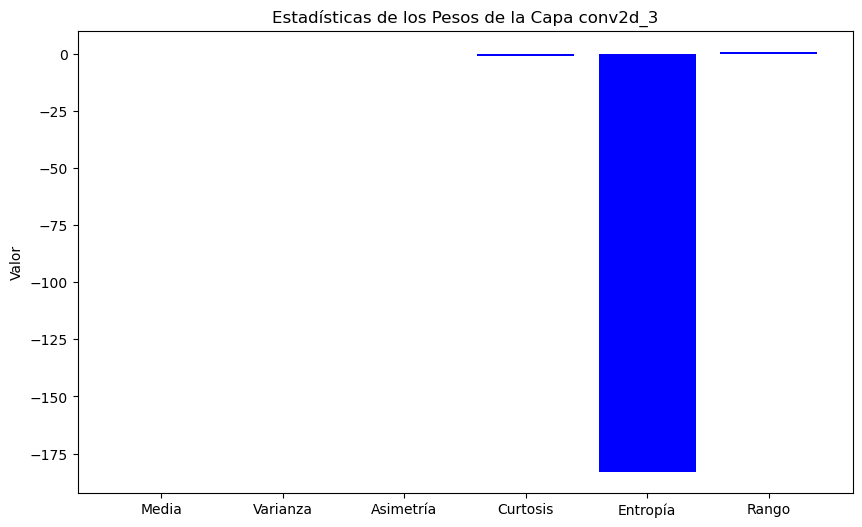

Capa: conv2d_4
  Media: 0.004213553853332996
  Varianza: 0.021954968571662903
  Asimetría: -0.05765617282768127
  Curtosis: -0.6288895553772762
  Entropía: -273.94592940937207
  Rango: 0.7790704965591431


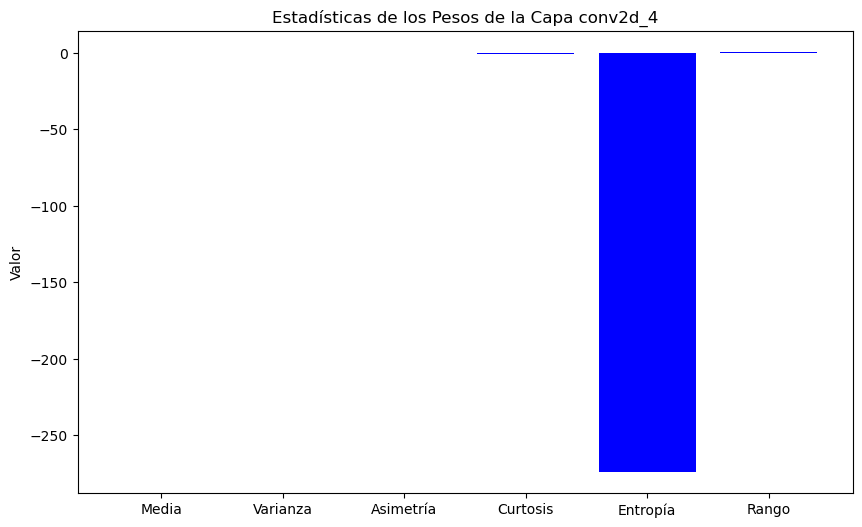

Capa: depthwise_conv2d_2
  Media: 0.013419542461633682
  Varianza: 0.006701014470309019
  Asimetría: -0.763143891105668
  Curtosis: -0.07762927055640834
  Entropía: -1201.036797090254
  Rango: 0.4409543573856354


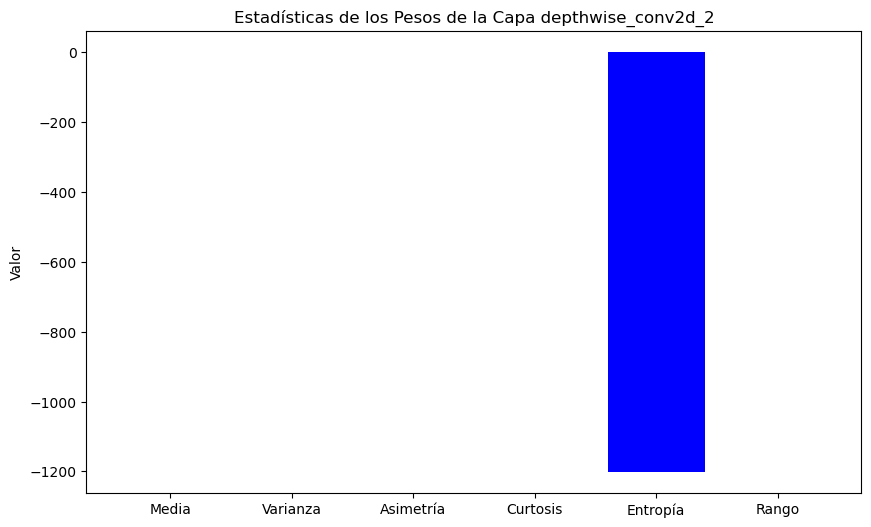

Capa: conv2d_5
  Media: -0.007560231257230043
  Varianza: 0.051024146378040314
  Asimetría: -0.010177473029296825
  Curtosis: -0.5741105467206764
  Entropía: -28.645912024645096
  Rango: 1.5327013731002808


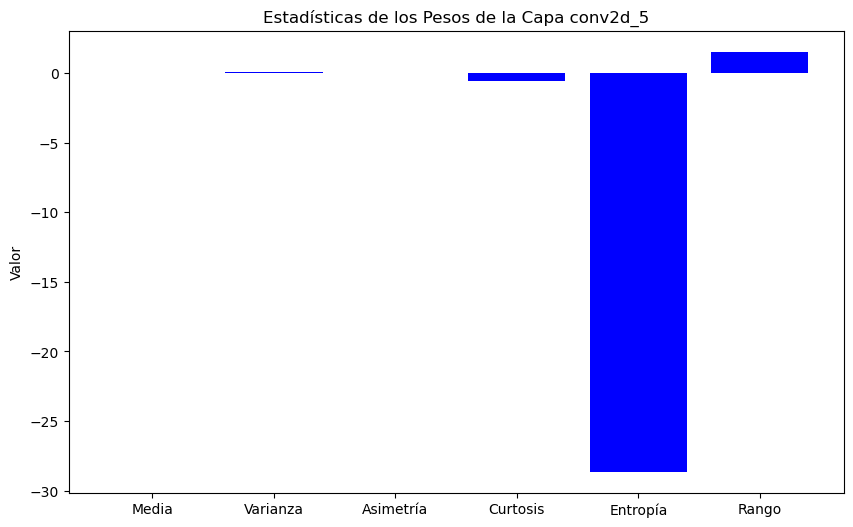

Capa: dense
  Media: 0.003523307852447033
  Varianza: 0.00494389608502388
  Asimetría: 0.16131147552755767
  Curtosis: 0.618724708955388
  Entropía: -1638.24304135225
  Rango: 0.48613983392715454


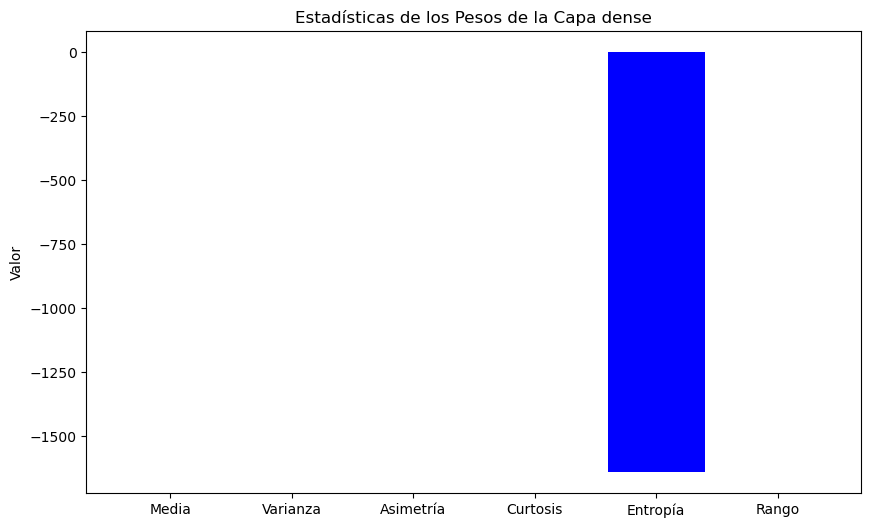

Capa: dense_1
  Media: -0.15555432438850403
  Varianza: 0.2801385223865509
  Asimetría: -0.6078949614252475
  Curtosis: 0.011955645524974745
  Entropía: 21.521564133665134
  Rango: 2.9124412536621094


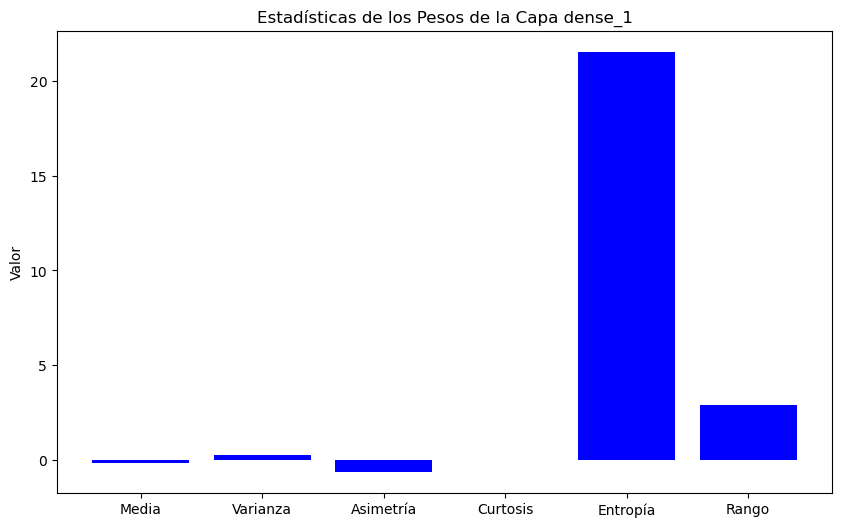

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from scipy.stats import kurtosis, skew

# Modelo original
model_input = model.input
layer_outputs = [layer.output for layer in model.layers]  # Obtenemos las salidas de todas las capas
activation_model = Model(inputs=model_input, outputs=layer_outputs)  # Modelo para activaciones

# Escoge una imagen del conjunto de entrenamiento para visualizar
img = imagenes_train[0]  # Puedes cambiar el índice para seleccionar otras imágenes
img = img.reshape(1, 128, 128, 3)  # Cambia el tamaño según la entrada del modelo

# Obtener las activaciones de todas las capas
activations = activation_model.predict(img)

# Visualizar activaciones para cada capa
images_per_row = 8

for layer_name, layer_activation in zip([layer.name for layer in model.layers], activations):
    print(f"Visualizando activaciones para la capa: {layer_name}")
    
    if len(layer_activation.shape) == 4:  # Si la salida es 4D (batch_size, height, width, channels)
        n_features = layer_activation.shape[-1]  # Número de filtros en la capa
        size = layer_activation.shape[1]  # Tamaño espacial de los mapas de características

        n_cols = n_features // images_per_row  # Número de columnas para organizar los gráficos
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()  # Normalizar para mejorar la visualización
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Visualizar el grid de activaciones
        scale = 1.0 / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()
    
    elif len(layer_activation.shape) == 2:  # Si la salida es 2D (batch_size, features)
        plt.figure(figsize=(10, 4))
        plt.title(f"Activaciones de la capa {layer_name}")
        plt.plot(layer_activation[0])
        plt.show()

    else:
        print(f"No se puede visualizar la activación de la capa {layer_name} de dimensión {len(layer_activation.shape)}")

# Visualización de pesos para todas las capas
for layer in model.layers:
    try:
        pesos, sesgos = layer.get_weights()

        # Número de filtros en la capa
        num_filtros = pesos.shape[-1]

        # Tamaño del grid para visualizar los filtros
        grid_size = int(np.ceil(np.sqrt(num_filtros)))

        # Visualizar los filtros
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        for i in range(num_filtros):
            filtro = pesos[:, :, 0, i]  # Extrayendo el filtro
            ax = axes[i // grid_size, i % grid_size]
            ax.imshow(filtro, cmap='viridis', aspect='auto')
            ax.axis('off')
        plt.suptitle(f'Pesos de la capa {layer.name}')
        plt.show()
    except:
        # Algunas capas pueden no tener pesos, como MaxPooling2D
        continue

# Cálculo y visualización de estadísticas de pesos para todas las capas
def calcular_entropia(pesos):
    hist, _ = np.histogram(pesos, bins=256, density=True)
    hist += 1e-7  # Evitar log(0)
    return -np.sum(hist * np.log2(hist))

for layer in model.layers:
    try:
        pesos, _ = layer.get_weights()

        # Calcular estadísticas
        media = np.mean(pesos)
        varianza = np.var(pesos)
        asimetria = skew(pesos.flatten())
        curtosis_val = kurtosis(pesos.flatten())
        entropia = calcular_entropia(pesos)
        rango_val = np.ptp(pesos)

        # Mostrar las estadísticas
        print(f"Capa: {layer.name}")
        print(f"  Media: {media}")
        print(f"  Varianza: {varianza}")
        print(f"  Asimetría: {asimetria}")
        print(f"  Curtosis: {curtosis_val}")
        print(f"  Entropía: {entropia}")
        print(f"  Rango: {rango_val}")

        # Graficar la evolución de las estadísticas
        estadisticas = ['Media', 'Varianza', 'Asimetría', 'Curtosis', 'Entropía', 'Rango']
        valores = [media, varianza, asimetria, curtosis_val, entropia, rango_val]

        plt.figure(figsize=(10, 6))
        plt.bar(estadisticas, valores, color='blue')
        plt.title(f'Estadísticas de los Pesos de la Capa {layer.name}')
        plt.ylabel('Valor')
        plt.show()

    except:
        # Algunas capas pueden no tener pesos, como MaxPooling2D
        continue




In [4]:
# Guardar en formato SavedModel
model.save("ruta_al_modelo/saved_model")

# Guardar en formato TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("ruta_al_modelo/model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: ruta_al_modelo/saved_model\assets


INFO:tensorflow:Assets written to: ruta_al_modelo/saved_model\assets


INFO:tensorflow:Assets written to: C:\Users\joshu\AppData\Local\Temp\tmpbiezfyfh\assets


INFO:tensorflow:Assets written to: C:\Users\joshu\AppData\Local\Temp\tmpbiezfyfh\assets


In [8]:
# Suponiendo que 'modelo' es el nombre de tu modelo en TensorFlow
model.save(r'C:\Users\joshu\OneDrive\Desktop/J2MPV1.h5')
